# Capstone Project Local Attempt

For this capstone project, I wanted to design and implement a dimensional data mart that represents a business with transactions using data detailing the exchange, ownership, and creation of NFTs. With this in mind, I used OpenSea (https://opensea.io) and other datasets from Kaggle shown below to generate the necessary databases and streaming to create dimensional tables and a fact table.

I used this Jupyter Notebook to create the SQL database "nft_history" in MySQL Workbench and the NoSQL database "nft_collections" in MongoDB. To create these databases, I drew from CSV files included in the folder from the following links: 
- https://www.kaggle.com/datasets/hemil26/nft-collections-dataset?resource=download
- https://www.kaggle.com/datasets/mathurinache/nft-history-sales
- https://www.kaggle.com/datasets/sudalairajkumar/nft-dataset-from-defillama?select=nft_dailyvolume.csv

These databases were then used to generated the dimensional tables and the fact table used in databricks.

## 1.0 Creating the Databases to Draw From.
#### Import Necessary Libraries

In [1]:
import os
import json
import numpy
import datetime
import pandas as pd
import csv
import requests
import requests.exceptions
import pymongo
from sqlalchemy import create_engine

#### Define Connection Variables - Please Replace With Appropriate Credentials

In [2]:
host_name = "localhost"
ports = {"mongo" : 27017, "mysql" : 3306}

user_id = "root" # CHANGE
pwd = "greg5que!" # CHANGE 

src_dbname = "nft_history"
dst_dbname = "nft_history"

In [3]:
# Go on ahead and connect to MongoDB for later
conn_str = f"mongodb://{host_name}:{ports['mongo']}/"
client = pymongo.MongoClient(conn_str)

#### Define Necessary Functions

In [4]:
def get_sql_dataframe(user_id, pwd, host_name, db_name, sql_query):
    # Create a connection to the MySQL database
    conn_str = f"mysql+pymysql://{user_id}:{pwd}@{host_name}/{db_name}"
    sqlEngine = create_engine(conn_str, pool_recycle=3600)
    
    #Invoke the pd.read_sql() function to query the database, and fill a Pandas DataFrame.
    conn = sqlEngine.connect()
    dframe = pd.read_sql(sql_query, conn);
    conn.close()
    
    return dframe

# Function for MongoDB for later part of this notebook...
def get_mongo_dataframe(user_id, pwd, host_name, port, db_name, collection, query):
    # Create a connection to MongoDB, with or without authentication credentials
    if user_id and pwd:
        mongo_uri = 'mongodb://%s:%s@%s:%s/%s' % (username, password, host, port, db_name)
        client = pymongo.MongoClient(mongo_uri)
    else:
        conn_str = f"mongodb://{host_name}:{port}/"
        client = pymongo.MongoClient(conn_str)
    
    # Query MongoDB, and fill a python list with documents to create a DataFrame 
    db = client[db_name]
    dframe = pd.DataFrame(list(db[collection].find(query)))
#     dframe.drop(['_id'], axis=1, inplace=True)
    client.close()
    
    return dframe

def set_dataframe(user_id, pwd, host_name, db_name, df, table_name, pk_column, db_operation):
    # Create a connection to the MySQL database
    conn_str = f"mysql+pymysql://{user_id}:{pwd}@{host_name}/{db_name}"
    sqlEngine = create_engine(conn_str, pool_recycle=3600)
    connection = sqlEngine.connect()
    
    # Invoke the Pandas DataFrame .to_sql( ) function to either create, or append to, a table
    if db_operation == "insert":
        df.to_sql(table_name, con=connection, index=False, if_exists='replace')
        sqlEngine.execute(f"ALTER TABLE {table_name} ADD PRIMARY KEY ({pk_column});")
            
    elif db_operation == "update":
        df.to_sql(table_name, con=connection, index=False, if_exists='append')
    
    connection.close()

### 1.1 Set Up MySQL data warehouse - "nft_history"

In [5]:
conn_str = f"mysql+pymysql://{user_id}:{pwd}@{host_name}"
sqlEngine = create_engine(conn_str, pool_recycle=3600)

sqlEngine.execute(f"DROP DATABASE IF EXISTS `{dst_dbname}`;")
sqlEngine.execute(f"CREATE DATABASE `{dst_dbname}`;")
sqlEngine.execute(f"USE {dst_dbname};")

db_name = "nft_history"

#### Read In Each CSV Into MySQL

In [6]:
#overall_sales
try:
    data_dir = os.path.join(os.getcwd())
    data_file = os.path.join(data_dir, 'overall_sales.csv')
    df = pd.read_csv(data_file, header=0, index_col=0)
except:
    print("Error loading overall_sales.csv")
# Referenced: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.to_sql.html

In [7]:
#Modifying the date in the tweets dataframe
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d', exact=True)
df['Date'] = df['Date'].dt.strftime('%Y-%m-%d')
df.to_sql("overall_sales", conn_str, schema="nft_history", if_exists='replace', index=False)
df.head(2)

,Date,Sales_USD_cumsum,Number_of_Sales_cumsum,Active_Market_Wallets_cumsum,Primary_Sales_cumsum,Secondary_Sales_cumsum,AverageUSD_cum,Sales_USD,Number_of_Sales,Active_Market_Wallets,Primary_Sales
Id,,,,,,,,,,,
1,2017-06-22,0.0,0,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN
2,2017-06-23,1020.3,19,8.0,0,19.0,53.7,1020.3,19.0,8.0,0.0


In [8]:
#chainlevel
try:
    data_dir = os.path.join(os.getcwd())
    data_file = os.path.join(data_dir, 'chainlevel.csv')
    df = pd.read_csv(data_file, header=0, index_col=0)
except:
    print("Error loading chainlevel.csv")

In [9]:
df.to_sql("chainlevel", conn_str, schema="nft_history", if_exists='replace', index=False)
df.head(2)

,displayName,chain,collections,dailyVolumeUSD,totalVolumeUSD
Id,,,,,
1,Ethereum,ethereum,5842,0,13466879582
2,ImmutableX,immutablex,100,0,66959373


In [10]:
#dailyvolume
try:
    data_dir = os.path.join(os.getcwd())
    data_file = os.path.join(data_dir, 'dailyvolume.csv')
    df = pd.read_csv(data_file, header=0, index_col=0)
except:
    print("Error loading dailyvolume.csv")

In [11]:
df.to_sql("dailyvolume", conn_str, schema="nft_history", if_exists='replace', index=False)
df.head(2)

,NFTMarket_DailyVolumeUSD,Date
Id,,
1,296,2018-01-23
2,1278,2018-01-25


### 1.2 Create The NoSQL Database - "nft_collections"

#### Convert CSV to JSON

In [12]:
# the below code is adapted from https://pythonexamples.org/python-csv-to-json/
def csv_to_json(csvFilePath, jsonFilePath):
    jsonArray = []
      
    #read csv file
    with open(csvFilePath, encoding='utf-8') as csvf: 
        #load csv file data using csv library's dictionary reader
        csvReader = csv.DictReader(csvf) 

        #convert each csv row into python dict
        for row in csvReader: 
            #add this python dict to json array
            jsonArray.append(row)
  
    #convert python jsonArray to JSON String and write to file
    with open(jsonFilePath, 'w', encoding='utf-8') as jsonf: 
        jsonString = json.dumps(jsonArray, indent=4)
        jsonf.write(jsonString)

In [13]:
#collections
try:
    csvFilePath = r'collections.csv'
    jsonFilePath = r'collections.json'
    csv_to_json(csvFilePath, jsonFilePath)
except:
    print("Error converting collections.csv to JSON file.")

In [14]:
#collection_sales
try:
    csvFilePath = r'collection_sales.csv'
    jsonFilePath = r'collection_sales.json'
    csv_to_json(csvFilePath, jsonFilePath)
except:
    print("Error converting collection_sales.csv to JSON file.")

#### Populate Mongo with Source Data - DO ONLY ONCE

In [15]:
src_dbname = "nft_collections"
port = ports["mongo"]
conn_str = f"mongodb://{host_name}:{port}/"
client = pymongo.MongoClient(conn_str)
db = client[src_dbname]

data_dir = os.path.join(os.getcwd())

json_files = {"collections" : 'collections.json',
            "collection_sales" : 'collection_sales.json'
             }

for file in json_files:
    json_file = os.path.join(data_dir, json_files[file])
    with open(json_file, 'r') as openfile:
        json_object = json.load(openfile)
        file = db[file]
        result = file.insert_many(json_object)
        #print(f"{file} was successfully loaded.")
        
client.close()

#### Validate Source Data in MongoDB

In [16]:
query = {}
port = ports["mongo"]
collection = "collections"

df_collections = get_mongo_dataframe(None, None, host_name, port, src_dbname, collection, query)
df_collections.head(2)

,_id,floorUSD,totalVolumeUSD,address,logo,marketplaces,name,chains,floor,owners,totalVolume,category,SK,PK,dailyVolumeUSD,dailyVolume,slug
0,627b16df53e617450e7bc1b2,0,2734505883,0xb47e3cd837ddf8e4c57f05d70ab865de6e193bbb,https://lh3.googleusercontent.com/BdxvLseXcfl5...,['opensea'],CryptoPunks,['ethereum'],0.0,3313,775319.649149289,collections,overview,collection#cryptopunks,1636712,464.06,cryptopunks
1,627b16df53e617450e7bc1b3,232425,1061782940,0xbc4ca0eda7647a8ab7c2061c2e118a18a936f13d,https://lh3.googleusercontent.com/Ju9CkWtV-1Ok...,['opensea'],Bored Ape Yacht Club,['ethereum'],65.9,6088,301049.3346361231,collections,overview,collection#boredapeyachtclub,6313610,1790.1099000000002,boredapeyachtclub


In [17]:
query = {}
port = ports["mongo"]
collection = "collection_sales"

df_collection_sales = get_mongo_dataframe(None, None, host_name, port, src_dbname, collection, query)
df_collection_sales.head(2)

,_id,Collections,Sales,Buyers,Txns,Owners
0,627b16df53e617450e7bc216,Axie Infinity,"$3,328,148,500","1,079,811","9,755,511","2,656,431"
1,627b16df53e617450e7bc217,CryptoPunks,"$1,664,246,968","4,723","18,961","3,289"


### 1.3 Draw Real-Time Data From the OpenSea API

#### Issue a Request to an API Endpoint
#### Exception Handling:
When attempting to connect to an HTTP endpoint, the following response **status_codes** may be returned:
- **200:** Everything went okay, and the result has been returned (if any).
- **301:** The server is redirecting you to a different endpoint. This can happen when a company switches domain names, or an endpoint name is changed.
- **400:** The server thinks you made a bad request. This can happen when you don’t send along the right data, among other things.
- **401:** The server thinks you’re not authenticated. Many APIs require login ccredentials, so this happens when you submit the wrong credentials.
- **403:** The resource you’re trying to access is forbidden: you don’t have the right perlessons to see it.
- **404:** The resource you tried to access wasn’t found on the server.
- **503:** The server is not ready to handle the request.

In [18]:
def get_api_response(url, response_type):
    try:
        response = requests.get(url)
        response.raise_for_status()
    
    except requests.exceptions.HTTPError as errh:
        return "An Http Error occurred: " + repr(errh)
    except requests.exceptions.ConnectionError as errc:
        return "An Error Connecting to the API occurred: " + repr(errc)
    except requests.exceptions.Timeout as errt:
        return "A Timeout Error occurred: " + repr(errt)
    except requests.exceptions.RequestException as err:
        return "An Unknown Error occurred: " + repr(err)

    if response_type == 'json':
        result = json.dumps(response.json(), sort_keys=True, indent=4)
    elif response_type == 'dataframe':
        result = pd.json_normalize(response.json())
    else:
        result = "An unhandled error has occurred!"
        
    return result

#### Unit test to ensure proper exception handling functionality

In [19]:
valid_url = "https://api.opensea.io/api/v1/collection/boredapeyachtclub/stats"
response_type = ['json', 'dataframe']

In [20]:
json_string = get_api_response(valid_url, response_type[0])
print(json_string)

{
    "stats": {
        "average_price": 21.597149231674344,
        "count": 9999.0,
        "floor_price": 99.69,
        "market_cap": 1109432.506312706,
        "num_owners": 6252,
        "num_reports": 176,
        "one_day_average_price": 104.9011975755,
        "one_day_change": -0.2895014878610446,
        "one_day_sales": 20.0,
        "one_day_volume": 2098.02395151,
        "seven_day_average_price": 110.9543460658772,
        "seven_day_change": -0.650850043840008,
        "seven_day_sales": 114.0,
        "seven_day_volume": 12648.795451510001,
        "thirty_day_average_price": 133.67041309849066,
        "thirty_day_change": 0.1115869372020207,
        "thirty_day_sales": 557.0,
        "thirty_day_volume": 74454.4200958593,
        "total_sales": 26084.0,
        "total_supply": 9999.0,
        "total_volume": 563340.0405589936
    }
}


In [21]:
import time
import datetime

In [22]:
df = get_api_response(valid_url, response_type[1])
x = datetime.datetime.now()
df.insert(0,'Date',x)
time.sleep(5)

In [23]:
counter = 1
while counter != 5: # add on another 4 instances of real-time API data
    df_new = get_api_response(valid_url, response_type[1])
    x = datetime.datetime.now()
    df_new.insert(0,'Date',x)
    df = df.append(df_new,ignore_index=True)
    time.sleep(5) # wait 5 seconds to grab another set of real-time data
    counter += 1

In [24]:
# validate
df

,Date,stats.one_day_volume,stats.one_day_change,stats.one_day_sales,stats.one_day_average_price,stats.seven_day_volume,stats.seven_day_change,stats.seven_day_sales,stats.seven_day_average_price,stats.thirty_day_volume,...,stats.thirty_day_average_price,stats.total_volume,stats.total_sales,stats.total_supply,stats.count,stats.num_owners,stats.average_price,stats.num_reports,stats.market_cap,stats.floor_price
0,2022-05-11 20:04:19.822953,2098.023952,-0.289501,20.0,104.901198,12648.795452,-0.65085,114.0,110.954346,74454.420096,...,133.670413,563340.040559,26084.0,9999.0,9999.0,6252,21.597149,176,1.109433e+06,99.69
1,2022-05-11 20:04:24.916024,2098.023952,-0.289501,20.0,104.901198,12648.795452,-0.65085,114.0,110.954346,74454.420096,...,133.670413,563340.040559,26084.0,9999.0,9999.0,6252,21.597149,176,1.109433e+06,99.69
2,2022-05-11 20:04:30.098364,2098.023952,-0.289501,20.0,104.901198,12648.795452,-0.65085,114.0,110.954346,74454.420096,...,133.670413,563340.040559,26084.0,9999.0,9999.0,6252,21.597149,176,1.109433e+06,99.69
3,2022-05-11 20:04:35.192767,2098.023952,-0.289501,20.0,104.901198,12648.795452,-0.65085,114.0,110.954346,74454.420096,...,133.670413,563340.040559,26084.0,9999.0,9999.0,6252,21.597149,176,1.109433e+06,99.69
4,2022-05-11 20:04:40.340545,2098.023952,-0.289501,20.0,104.901198,12648.795452,-0.65085,114.0,110.954346,74454.420096,...,133.670413,563340.040559,26084.0,9999.0,9999.0,6252,21.597149,176,1.109433e+06,99.69


## 2.0 Creating the Data Mart with Dimensional Tables and a Fact Table
### 2.1 Create the new Data Warehouse

In [25]:
dst_dbname = "nft_dw"
conn_str = f"mysql+pymysql://{user_id}:{pwd}@{host_name}"
sqlEngine = create_engine(conn_str, pool_recycle=3600)

sqlEngine.execute(f"DROP DATABASE IF EXISTS `{dst_dbname}`;")
sqlEngine.execute(f"CREATE DATABASE `{dst_dbname}`;")
sqlEngine.execute(f"USE {dst_dbname};")

### 2.2 Create the Dimension Tables
#### dim_collections - this dimension table represents the collections and collection statistics (the "sellers"). 
- NoSQL: nft_collections.collections
- NoSQL: nft_collections.collection_sales

In [26]:
# Load source dataframe 1
query = {}
port = ports["mongo"]
collection = "collections"
df_collections = get_mongo_dataframe(None, None, host_name, port, src_dbname, collection, query)
# df_collections.head(2)

In [27]:
# Perform necessary transformations
drop_cols = ['floorUSD','_id','logo','marketplaces','floor','owners','totalVolume','category','SK','PK','dailyVolume','slug']
df_collections.drop(drop_cols, axis=1, inplace=True)
df_collections.rename(columns={
    "totalVolumeUSD":"total_volume",
    "address":"address",
    "chains":"chain",
    "dailyVolumeUSD":"daily_volume",
    "name":"collections"
    }, inplace=True)
df_collections['collections']=df_collections['collections'].astype(str)
df_collections.head(2)

,total_volume,address,collections,chain,daily_volume
0,2734505883,0xb47e3cd837ddf8e4c57f05d70ab865de6e193bbb,CryptoPunks,['ethereum'],1636712
1,1061782940,0xbc4ca0eda7647a8ab7c2061c2e118a18a936f13d,Bored Ape Yacht Club,['ethereum'],6313610


In [28]:
# Load source dataframe 2
query = {}
port = ports["mongo"]
collection = "collection_sales"
df_collection_sales = get_mongo_dataframe(None, None, host_name, port, src_dbname, collection, query)
# df_collection_sales.head(2)

In [29]:
# Perform necessary transformations 2
df_collection_sales.drop('Txns',axis=1, inplace=True)
df_collection_sales.rename(columns={
    "Collections":"collections",
    "Sales":"sales",
    "Buyers":"buyers",
    "Owners":"owners",
    }, inplace=True)
df_collection_sales['collections']=df_collection_sales['collections'].astype(str)
df_collection_sales.head(2)

,_id,collections,sales,buyers,owners
0,627b16df53e617450e7bc216,Axie Infinity,"$3,328,148,500","1,079,811","2,656,431"
1,627b16df53e617450e7bc217,CryptoPunks,"$1,664,246,968","4,723","3,289"


In [30]:
df_collections = pd.merge(df_collections, df_collection_sales, on='collections', how='inner')
df_collections.insert(loc=0, column='collection_id', value=range(1, len(df_collections)+1))
df_collections.head(4)

,collection_id,total_volume,address,collections,chain,daily_volume,_id,sales,buyers,owners
0,1,2734505883,0xb47e3cd837ddf8e4c57f05d70ab865de6e193bbb,CryptoPunks,['ethereum'],1636712,627b16df53e617450e7bc217,"$1,664,246,968","4,723","3,289"
1,2,2734505883,0xb47e3cd837ddf8e4c57f05d70ab865de6e193bbb,CryptoPunks,['ethereum'],1636712,627c4f0374f63a690a8ca18e,"$1,664,246,968","4,723","3,289"
2,3,2734505883,0xb47e3cd837ddf8e4c57f05d70ab865de6e193bbb,CryptoPunks,['ethereum'],1636712,627b16df53e617450e7bc217,"$1,664,246,968","4,723","3,289"
3,4,2734505883,0xb47e3cd837ddf8e4c57f05d70ab865de6e193bbb,CryptoPunks,['ethereum'],1636712,627c4f0374f63a690a8ca18e,"$1,664,246,968","4,723","3,289"


In [31]:
dataframe = df_collections
table_name = 'dim_collections'
primary_key = 'collection_id'
db_operation = "insert"

set_dataframe(user_id, pwd, host_name, dst_dbname, dataframe, table_name, primary_key, db_operation)

#### dim_sales - this table represents the statistic surrounding the sale and exchange of the NFTS (the "buyers").
- SQL: nft_history.overall_sales
- API: real-time data

In [32]:
# Load source dataframe 1
src_dbname = "nft_history"
sql_overall_sales = "SELECT * FROM nft_history.overall_sales;"
df_overall_sales = get_sql_dataframe(user_id, pwd, host_name, src_dbname, sql_overall_sales)
# df_overall_sales.head(2)

In [33]:
# Perform necessary transformations 1
df_overall_sales['Date'] = pd.to_datetime(df["Date"].dt.strftime('%Y-%m-%d %H:%M:%S'))
drop_cols = ['Sales_USD','Secondary_Sales_cumsum','AverageUSD_cum','Number_of_Sales','Active_Market_Wallets','Primary_Sales']
df_overall_sales.drop(drop_cols, axis=1, inplace=True)
df_overall_sales.rename(columns={
    "Date":"date",
    "Sales_USD_cumsum":"cumulative_sales",
    "Number_of_Sales_cumsum":"sales_count",
    "Active_Market_Wallets_cumsum":"active_wallets",
    "Primary_Sales_cumsum":"primary_sales_cumulative",
    }, inplace=True)
df_overall_sales.head(2)

,date,cumulative_sales,sales_count,active_wallets,primary_sales_cumulative
0,2022-05-11 20:04:19,0.0,0,0.0,0
1,2022-05-11 20:04:24,1020.3,19,8.0,0


In [34]:
# Api response
# df.head(2)

In [35]:
# Perform necessary transformations API response
df['Date'] = pd.to_datetime(df["Date"].dt.strftime('%Y-%m-%d %H:%M:%S'))
drop_cols = ['stats.one_day_volume','stats.one_day_change','stats.one_day_sales','stats.one_day_average_price',
             'stats.seven_day_volume','stats.seven_day_change','stats.seven_day_average_price',
            'stats.thirty_day_volume','stats.thirty_day_average_price','stats.total_volume','stats.total_supply',
            'stats.average_price','stats.floor_price','stats.market_cap','stats.thirty_day_sales',
            'stats.seven_day_sales','stats.thirty_day_change']
df.drop(drop_cols, axis=1, inplace=True)
df.rename(columns={
    "Date":"date",
    "stats.num_owners":"active_wallets",
    "stats.total_sales":"cumulative_sales",
    "stats.num_reports":"sales_count",
    "stats.count":"primary_sales_cumulative"
    }, inplace=True)
df.head(2)

,date,cumulative_sales,primary_sales_cumulative,active_wallets,sales_count
0,2022-05-11 20:04:19,26084.0,9999.0,6252,176
1,2022-05-11 20:04:24,26084.0,9999.0,6252,176


In [36]:
df_overall_sales = df_overall_sales.append(df,ignore_index=True, sort=True)
df_overall_sales.insert(loc=0, column='sales_id', value=range(1, len(df_overall_sales)+1))
df_overall_sales.head(2)

,sales_id,active_wallets,cumulative_sales,date,primary_sales_cumulative,sales_count
0,1,0.0,0.0,2022-05-11 20:04:19,0.0,0
1,2,8.0,1020.3,2022-05-11 20:04:24,0.0,19


In [37]:
dataframe = df_overall_sales
table_name = 'dim_sales'
primary_key = 'sales_id'
db_operation = "insert"

set_dataframe(user_id, pwd, host_name, dst_dbname, dataframe, table_name, primary_key, db_operation)

#### dim_chainlevel - this dimension table represents the blockchain networks used to mint and exchange the NFTs (the "marketplace").
- SQL: nft_history.chainlevel

In [38]:
# Extract data from the source database for chainlevel
sql_chainlevel = "SELECT * FROM nft_history.chainlevel;"
df_chainlevel = get_sql_dataframe(user_id, pwd, host_name, src_dbname, sql_chainlevel)
# df_chainlevel.head(2)

In [39]:
# Tranform that data for chainlevel
df_chainlevel.drop('dailyVolumeUSD',axis=1,inplace=True)
df_chainlevel.rename(columns={
    "displayName":"network_name",
    "chain":"chain_name",
    "collections":"collection_count",
    "totalVolumeUSD":"total_volume"
    }, inplace=True)
df_chainlevel.insert(loc=0, column='network_id', value=range(1, len(df_chainlevel)+1))
df_chainlevel.head(2)

,network_id,network_name,chain_name,collection_count,total_volume
0,1,Ethereum,ethereum,5842,13466879582
1,2,ImmutableX,immutablex,100,66959373


In [40]:
dataframe = df_chainlevel
table_name = 'dim_chainlevel'
primary_key = 'network_id'
db_operation = "insert"

set_dataframe(user_id, pwd, host_name, dst_dbname, dataframe, table_name, primary_key, db_operation)

### 2.3 Create the Fact Table

#### fact_collections

In [41]:
# Load source dataframe 1
src_dbname = "nft_history"
sql_dim_collections = "SELECT * FROM nft_dw.dim_collections;"
df_dim_collections = get_sql_dataframe(user_id, pwd, host_name, src_dbname, sql_dim_collections)
df_dim_collections.head(2)

,collection_id,total_volume,address,collections,chain,daily_volume,_id,sales,buyers,owners
0,1,2734505883,0xb47e3cd837ddf8e4c57f05d70ab865de6e193bbb,CryptoPunks,['ethereum'],1636712,627b16df53e617450e7bc217,"$1,664,246,968","4,723","3,289"
1,2,2734505883,0xb47e3cd837ddf8e4c57f05d70ab865de6e193bbb,CryptoPunks,['ethereum'],1636712,627c4f0374f63a690a8ca18e,"$1,664,246,968","4,723","3,289"


In [42]:
# Load source dataframe 1
sql_dim_chainlevel = "SELECT * FROM nft_dw.dim_chainlevel;"
df_dim_chainlevel = get_sql_dataframe(user_id, pwd, host_name, src_dbname, sql_dim_chainlevel)
df_dim_chainlevel.head(2)

,network_id,network_name,chain_name,collection_count,total_volume
0,1,Ethereum,ethereum,5842,13466879582
1,2,ImmutableX,immutablex,100,66959373


In [43]:
df_dim_chainlevel['chain_name']= "['"+df_dim_chainlevel['chain_name']+"']"
df_dim_chainlevel.head(2)

,network_id,network_name,chain_name,collection_count,total_volume
0,1,Ethereum,['ethereum'],5842,13466879582
1,2,ImmutableX,['immutablex'],100,66959373


In [44]:
df_fact_collections = df_dim_collections
for t in range(len(df_dim_chainlevel)):
    for i in range(len(df_dim_collections)):
        if(df_dim_chainlevel.iat[t,2] == df_dim_collections.iat[i,4]):
            # df.insert(position, 'col_name', [value1, value2, value3, ...])
            w = 0
            while w != 4:
                df_fact_collections.insert((4+w), str(df_chainlevel.columns[w]), df_chainlevel.iat[t,w])
                w += 1
               
df_fact_collections.head(2)

,collection_id,total_volume,address,collections,network_id,network_name,chain_name,collection_count,chain,daily_volume,_id,sales,buyers,owners
0,1,2734505883,0xb47e3cd837ddf8e4c57f05d70ab865de6e193bbb,CryptoPunks,1,Ethereum,ethereum,5842,['ethereum'],1636712,627b16df53e617450e7bc217,"$1,664,246,968","4,723","3,289"
1,2,2734505883,0xb47e3cd837ddf8e4c57f05d70ab865de6e193bbb,CryptoPunks,1,Ethereum,ethereum,5842,['ethereum'],1636712,627c4f0374f63a690a8ca18e,"$1,664,246,968","4,723","3,289"


In [45]:
dataframe = df_fact_collections
table_name = 'fact_collections'
primary_key = 'collection_id'
db_operation = "insert"

set_dataframe(user_id, pwd, host_name, dst_dbname, dataframe, table_name, primary_key, db_operation)

### 2.4 Validate Fact & Dimension Tables

## 3.0 Data Visualizations

### 3.1 Export to Microsoft Excel

In [46]:
excel_writer = "~/Desktop/nft_fact_collections.xlsx"
# df_fact_collections.to_excel(excel_writer)

### 3.2 In Excel, Create Visualizations as Shown Below

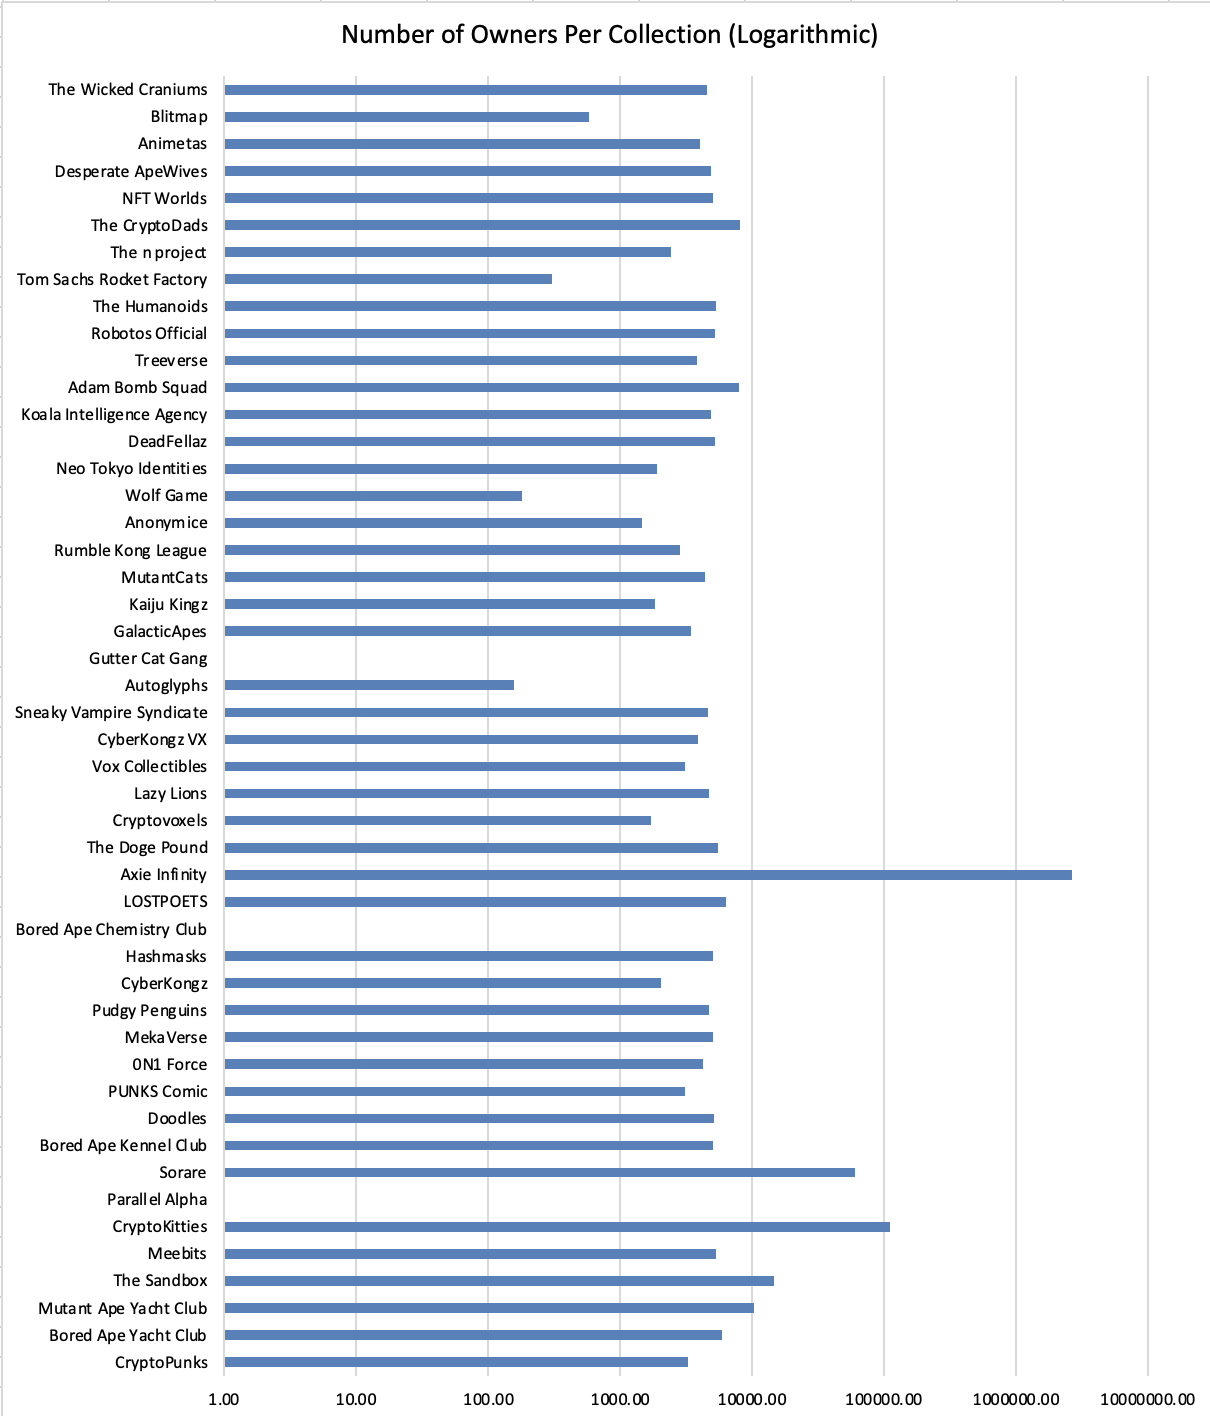

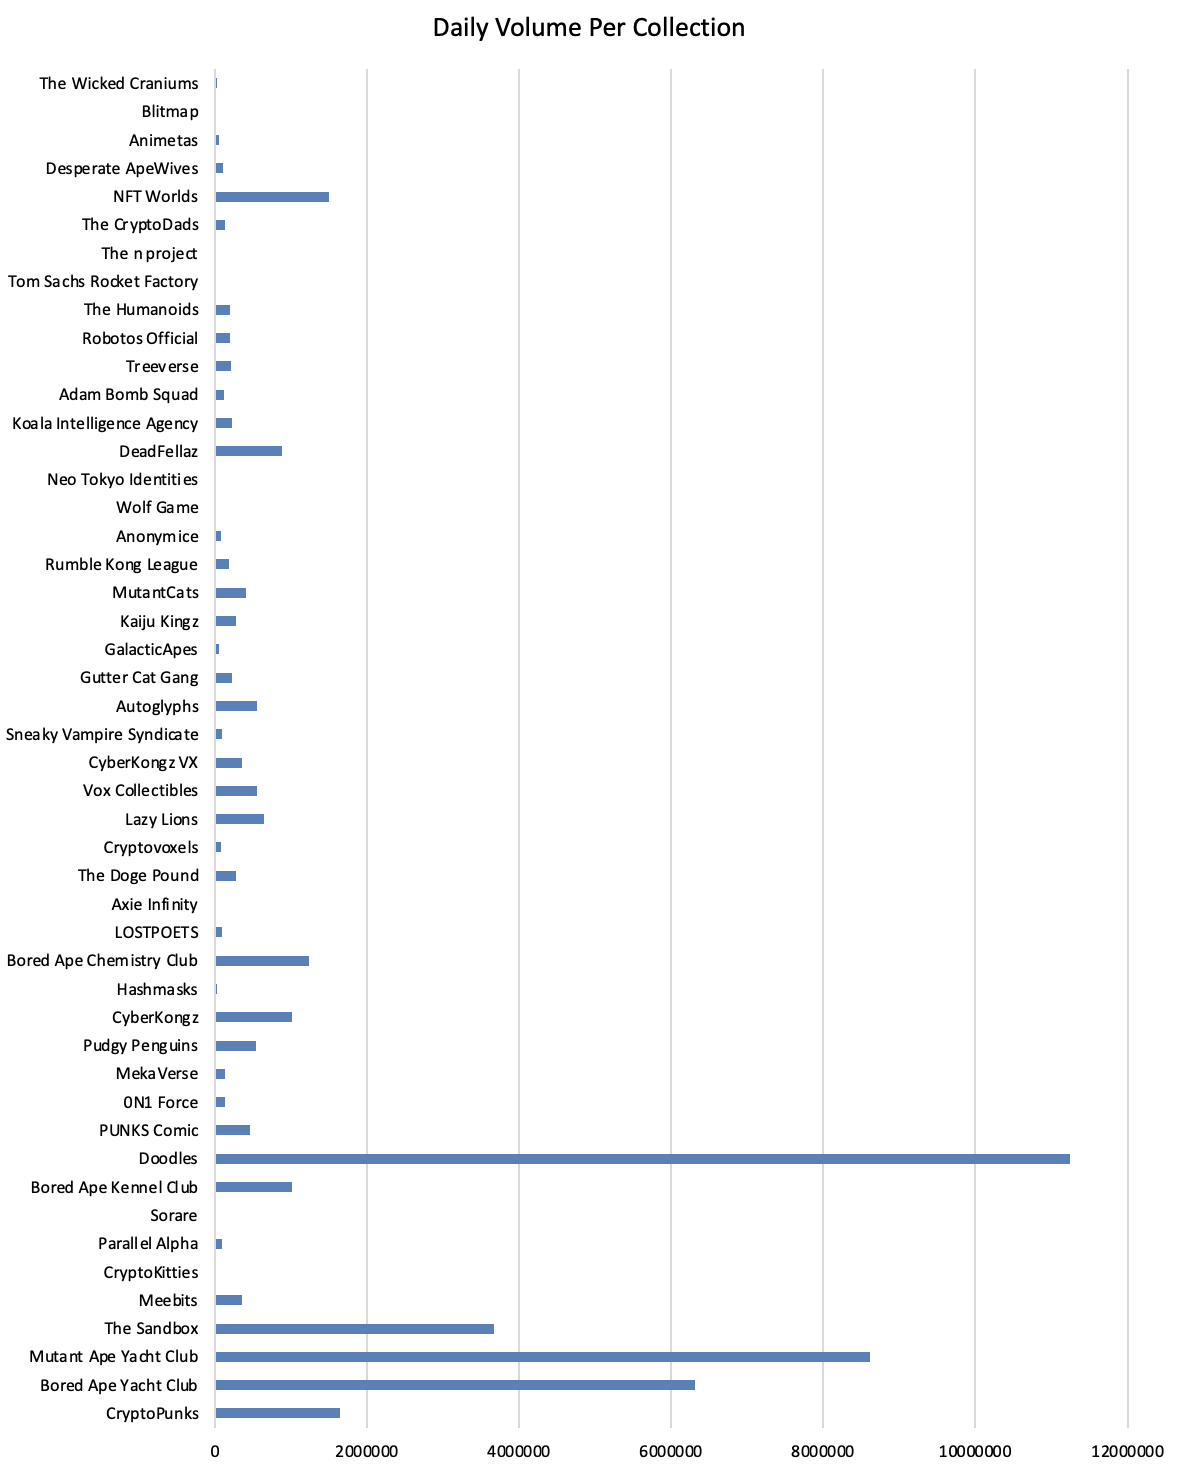